# Lecture 11 notebook demo 3: Posterior predictive checks

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from pymc3 import glm
import arviz as az

### Create OK turbines data set

In [30]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


In [31]:
# Turbines in Oklahoma (where the wind comes sweepin' down the plain...)
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

### Draw posterior samples from Gaussian, Poisson and negative binomial models

In [4]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)

with pm.Model() as gaussian_model:
    # Specify glm and pass in data. This is similar to the code from
    # Lab 3 that created `theta = pm.Beta(...)`, etc., but using PyMC3's 
    # GLM module sets everything up automaticaly. 
    # The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('log_totals ~ year', ok_turbines)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [5]:
# Not counting variable name changes, there are two differences 
# between this cell and the version we did before: can you find them?
with pm.Model() as poisson_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
# Not counting variable name changes, there's only one difference
# between this cell and the Poisson regression code: can you find it?

with pm.Model() as negbin_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


### Draw posterior predictive samples from Gaussian, Poisson and negative binomial models

In [7]:
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=["year", "Intercept", "y"]
    )

In [8]:
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["year", "Intercept", "y"]
    )

In [9]:
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["year", "Intercept", "y"]
    )

In [35]:
negbin_ppc["year"].shape

(2000,)

### Plot posterior predictive distribution for each model

In [17]:
# Compute the posterior regression function (y hat values) for each model
y_hat_poisson = np.exp(np.outer(poisson_ppc["year"], ok_turbines.year.values) + poisson_ppc["Intercept"][:,np.newaxis])
y_hat_negbin = np.exp(np.outer(negbin_ppc["year"], ok_turbines.year.values) + negbin_ppc["Intercept"][:,np.newaxis])
y_hat_gaussian = np.exp(np.outer(gaussian_ppc["year"], ok_turbines.year.values) + gaussian_ppc["Intercept"][:,np.newaxis])
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

In [37]:
y_hat_negbin.shape

(2000, 17)

/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


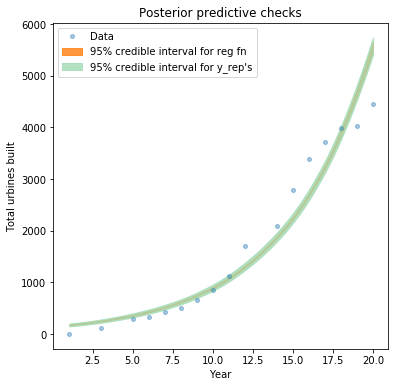

In [38]:
_, ax = plt.subplots(figsize = (6,6))

ax.plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
az.plot_hpd(
    ok_turbines.year,
    y_hat_poisson,
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
)
az.plot_hpd(
    ok_turbines.year,
    poisson_ppc["y"],
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
)

ax.set_xlabel("Year")
ax.set_ylabel("Total urbines built")
ax.set_title("Posterior predictive checks")
ax.legend(fontsize=10);

/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other

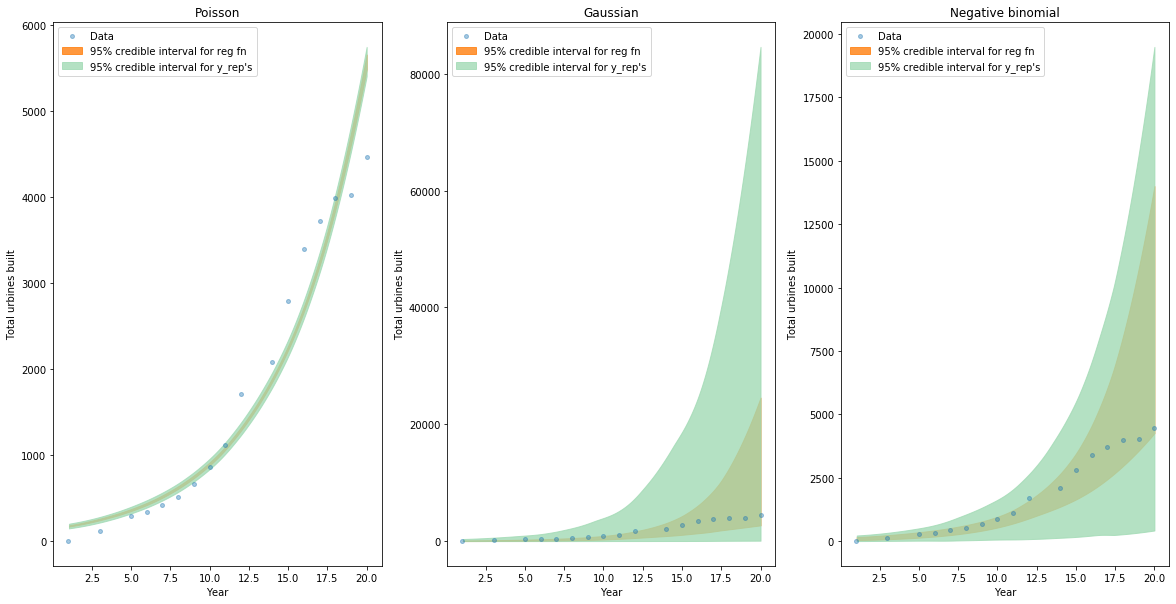

In [25]:
_, ax = plt.subplots(1,3, figsize = (20,10))
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hpd(
        ok_turbines.year,
        y_hat_vals[idx],
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]
    az.plot_hpd(
        ok_turbines.year,
        pp_y,
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax[idx].set_xlabel("Year")
    ax[idx].set_ylabel("Total urbines built")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)